[[0.16349885 0.05430969 0.04352951 0.73866194]]
Total time to predict Image : 2.076


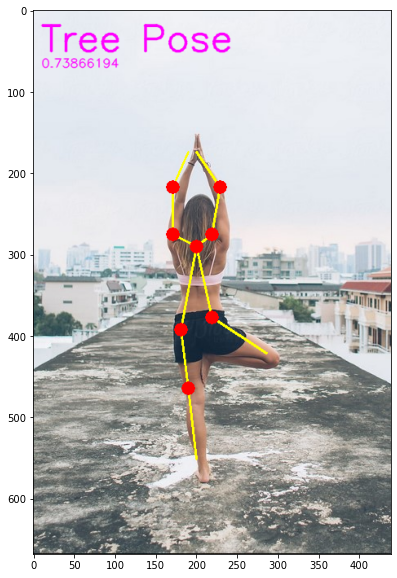

In [4]:
import cv2
import matplotlib.pyplot as plt
%matplotlib inline
import time
import numpy as np
from keras.models import load_model
from sklearn.metrics import classification_report
from xgboost import XGBClassifier

model = XGBClassifier()
model.load_model('models/xgboost.model')
protoFile = "pose/coco/pose_deploy_linevec.prototxt"
weightsFile = "pose/coco/pose_iter_440000.caffemodel"
nPoints = 18
POSE_PAIRS = [[1,0],[1,2],[1,5],[2,3],[3,4],[5,6],[6,7],[1,8],[8,9],[9,10],[1,11],[11,12],[12,13],[0,14],[0,15],[14,16],[15,17]]

frame = cv2.imread("test/test4.jpg")
frameCopy = np.copy(frame)
frameWidth = frame.shape[1]
frameHeight = frame.shape[0]
threshold = 0.1

net = cv2.dnn.readNetFromCaffe(protoFile, weightsFile)

t = time.time()
# input image dimensions for the network
inWidth = 368
inHeight = 368
inpBlob = cv2.dnn.blobFromImage(frame, 1.0 / 255, (inWidth, inHeight),
                          (0, 0, 0), swapRB=False, crop=False)

net.setInput(inpBlob)

output = net.forward()

H = output.shape[2]
W = output.shape[3]

# Empty list to store the detected keypoints
points = []
predict_points = []

def getPose(poseIndex):
    if poseIndex == 0:
        return "Warrior Pose 1"
    if poseIndex == 1:
        return "Warrior Pose 2"
    if poseIndex == 2:
        return "Warrior Pose 3"
    if poseIndex == 3:
        return "Tree Pose"

for i in range(nPoints):
    # confidence map of corresponding body's part.
    probMap = output[0, i, :, :]

    # Find global maxima of the probMap.
    minVal, prob, minLoc, point = cv2.minMaxLoc(probMap)
    
    # Scale the point to fit on the original image
    x = (frameWidth * point[0]) / W
    y = (frameHeight * point[1]) / H

    if prob > threshold : 
        cv2.circle(frameCopy, (int(x), int(y)), 8, (0, 255, 255), thickness=-1, lineType=cv2.FILLED)
        cv2.putText(frameCopy, "{}".format(i), (int(x), int(y)), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2, lineType=cv2.LINE_AA)

        # Add the point to the list if the probability is greater than the threshold
        points.append((int(x), int(y)))
        predict_points.append((float(x), float(y)))
    else :
        points.append(None)
        predict_points.append((0,0))

predict_points = [element for tupl in predict_points for element in tupl]
predict_points = np.asarray(predict_points)
predict_points = np.expand_dims(predict_points, axis=0)
classPred = model.predict(predict_points)
probPred = model.predict_proba(predict_points)
print(probPred)
probPred = np.squeeze(probPred)
prediction = getPose(classPred[0])
# Draw Skeleton
for pair in POSE_PAIRS:
    partA = pair[0]
    partB = pair[1]

    if points[partA] and points[partB]:
        cv2.line(frame, points[partA], points[partB], (0, 255, 255), 2)
        cv2.circle(frame, points[partA], 8, (0, 0, 255), thickness=-1, lineType=cv2.FILLED)


# cv2.imshow('Output-Keypoints', frameCopy)
frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
cv2.putText(frame, text=prediction, org=(10,50), fontFace=cv2.FONT_HERSHEY_SIMPLEX, fontScale=1.5, color=(255,0,255), thickness=2, lineType=cv2.LINE_AA)
cv2.putText(frame, text=str(probPred[classPred[0]]), org=(10,70), fontFace=cv2.FONT_HERSHEY_SIMPLEX, fontScale=0.5, color=(255,0,255), thickness=1, lineType=cv2.LINE_AA)
# cv2.imshow('Output-Skeleton', frame)


print("Total time to predict Image : {:.3f}".format(time.time() - t))
plt.figure(figsize=(10,10))
plt.imshow(frame)